##Assessing Science impact of PSV in LSST sensors

To assess the science impact of pixel size variation in LSST sensors, we will need to lay down sources with the following varying properties:
- focal plane position ( x in [50,3950]; y in [50,3950] with half-pixel step size
- ellipticity of source ( e in [0,1])
- orientation of source (theta in [0,180 degrees])

##Setting up ipcluster controller
After manually start cluster in "clusters" tab on home page

In [107]:
!bjobs

No unfinished job found


In [3]:
a = !bjobs
len(a)-1

50

In [74]:
profile="lsf_parallel" # "wakari" will use ssh to remote nodes - change to "default" if necessary
from IPython.parallel import *
client = Client(profile=profile)
N_nodes = len(client.ids)
print 'Now controlling ' + str(N_nodes) + ' workers on LSF farm'
least_busy = client.load_balanced_view()
all_workers = client[:]
least_busy.block = False
all_workers.block   = False

def checkhostname():
    import socket
    return socket.gethostname()

hostnames = all_workers.apply(checkhostname)
print hostnames.get()

Now controlling 2 workers on LSF farm
['hequ0136', 'hequ0144']


In [53]:
import itertools
import numpy as np
evec = np.arange(0,.91,.1)
svec = np.arange(2,6.1,1)
tvec = np.arange(0,90.1,45)
fvec = np.array([1,3,5,7])
param_vec = [item for item in itertools.product(evec,svec,tvec,fvec)]
local_str = 'I live on local'

@all_workers.parallel(block=True)
def runAna(param_vec):
    import numpy as np
    out = []
    for pars in param_vec:
        out.append(np.array(pars)**3)
    return out

#all_workers.scatter('param_vec',param_vec)

In [54]:
len(param_vec)

600

In [17]:
param_vec = [[0,5,0,5],[.5,4,45,7]]

In [19]:
%magic

In [39]:
#%%writefile batchScienceAna.py
def doGridAna(params):
    import sys, os
    sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
    import pandas as pd
    import copy
    import numpy as np
    from weak_sauce.grid import MoveableGrid
    from weak_sauce.sources import Source
    from weak_sauce.movers import FixedIlluminationMover, SimpleVerticesMover, UniformIlluminationMover
    import galsim

    #for LSST
    #saved_mg = MoveableGrid('../data/test100k_iter.pkl')
    #flat=np.load('7th_order_LSST_50x50.npy')
    
    saved_mg = MoveableGrid('../data/best_lsst_amp3_mg.pkl')
    flat = np.load('../data/big_lsst_flat.npy')

    cutout_side_length = 64 #should be even
    
    res_df_list = []
    res_df = pd.DataFrame()
    
    #psf = galsim.Moffat(4.765,fwhm=4.5)
    
    obj = galsim.Gaussian(fwhm=params[1],flux=params[3])
    #obj = galsim.Sersic(4,half_light_radius=params[1]) #deV profile        
    #obj = galsim.Convolve(obj,psf)
    obj = obj.shift(cutout_side_length/2,cutout_side_length/2)
    obj = obj.shear(e=params[0],beta=galsim.Angle(params[2],galsim.degrees))
    
    #oversampled galaxy to plop down
    stationary_source = Source(num_x=5*(cutout_side_length)+1, flux_func=obj)
    illuminator = FixedIlluminationMover(stationary_source)
    areaFinder = UniformIlluminationMover()
    
    ideal_grid = Source(num_x=cutout_side_length+1)
    ideal_mg = MoveableGrid(ideal_grid,illuminator)
    ideal_mg.step()
    #ideal_mg.source.plot_pixel_grid()
    ideal_res = ideal_mg.evaluate_psf()
    ideal_sex_res = ideal_mg.evaluate_sex()['FLUX_AUTO']
    if len(ideal_sex_res == 0): ideal_res['FLUX_AUTO'] = ideal_sex_res[0]
    else: ideal_res['FLUX_AUTO'] = 0
    print ideal_res['FLUX_AUTO']
    #ideal_mg.plot_pixel_grid()
    
    for xctr in np.floor(np.linspace(cutout_side_length/2+1,flat.shape[0]-cutout_side_length/2-1,num=4)):
        for yctr in np.floor(np.linspace(cutout_side_length/2+1,flat.shape[1]-cutout_side_length/2-1,num=4)):
            temp = Source(num_x=cutout_side_length+2)
            #print temp.vertices
            print xctr, yctr
            temp.vertices = saved_mg.source.vertices[xctr-cutout_side_length/2:xctr+cutout_side_length/2+2,\
                                                     yctr-cutout_side_length/2:yctr+cutout_side_length/2+2,:].copy()
            #print temp.vertices
            cutoutMover = SimpleVerticesMover(mu_x=(cutout_side_length/2-xctr),mu_y=(cutout_side_length/2-yctr))
            shiftingGrid = MoveableGrid(temp,cutoutMover)
            shiftingGrid.step()
            temp.update_centroids()
            areaFindingGrid = MoveableGrid(temp,areaFinder)
            areaFindingGrid.step()
            #temp.fluxes = saved_mg.source.fluxes[yctr-cutout_side_length/2:yctr+cutout_side_length/2, \
            #                                     xctr-cutout_side_length/2:xctr+cutout_side_length/2]
            temp.fluxes -= 1
            #print temp.fluxes.shape
          
            #temp.plot_pixel_grid()
            mg = MoveableGrid(temp, illuminator)
            mg.step()
            mg.source.fluxes /= flat[xctr-cutout_side_length/2:xctr+cutout_side_length/2+1,\
                                     yctr-cutout_side_length/2:yctr+cutout_side_length/2+1]
            #mg.plot_pixel_grid()
            fitted_res = mg.evaluate_psf()
            sex_res = mg.evaluate_sex()['FLUX_AUTO']
            if len(sex_res == 0): fitted_res['FLUX_AUTO'] = sex_res[0]
            else: ideal_res['FLUX_AUTO'] = 0
            #print fitted_res
            residual = fitted_res-ideal_res
            residual['xctr'] = xctr
            residual['yctr'] = yctr
            res_df = res_df.append(residual)
            
    res_df["inputE"] = params[0]
    res_df["inputS"] = params[1]
    res_df["inputTheta"] = params[2]
    res_df.to_pickle(os.path.expandvars('$LSST_DATA/scienceImpactDFs/lsst_chip03_e'++'_s'++'_t'++'_f'+str(params[3]))
    return

0    4.994105
Name: FLUX_AUTO, dtype: float64
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
33.0 33.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
33.0 585.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
33.0 1137.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
33.0 1689.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
91.0 33.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
91.0 585.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
91.0 1137.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
91.0 1689.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
150.0 33.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
150.0 585.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
150.0 1137.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
150.0 1689.0
Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!
209.0 33.0
Warning! plot_naieve_grid deprecated!

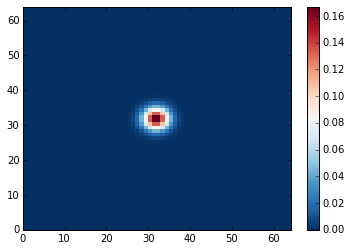

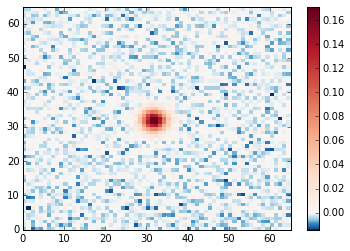

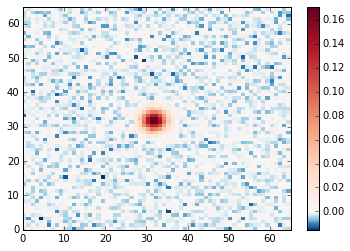

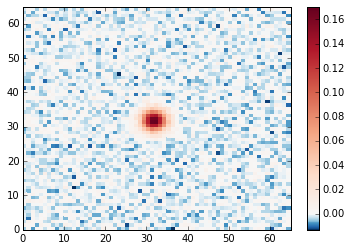

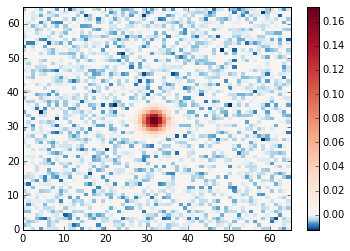

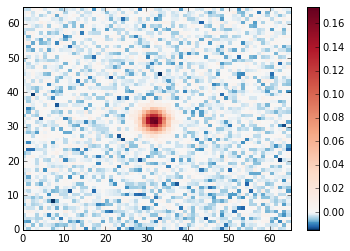

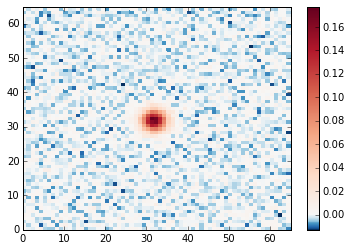

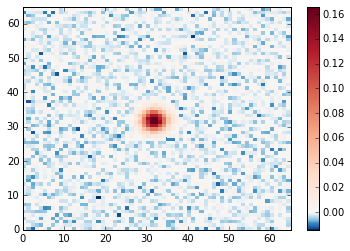

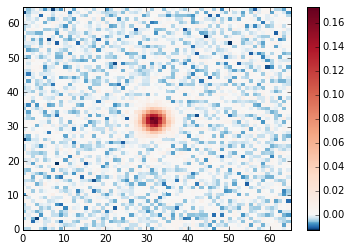

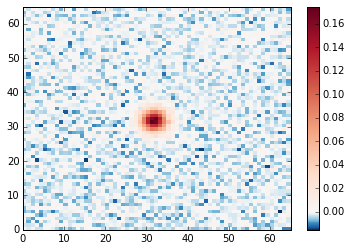

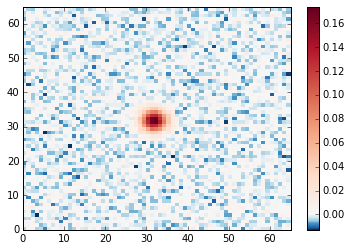

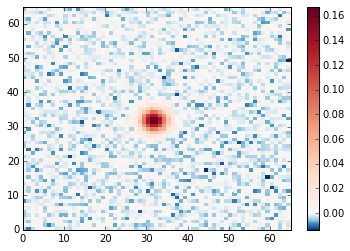

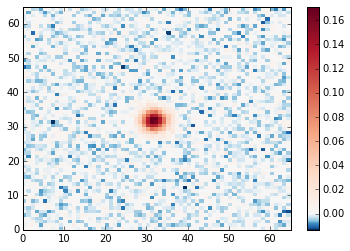

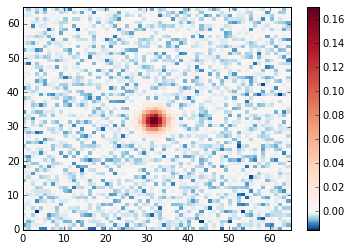

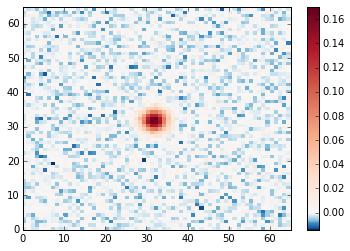

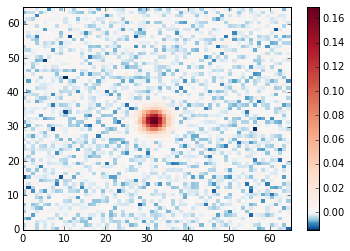

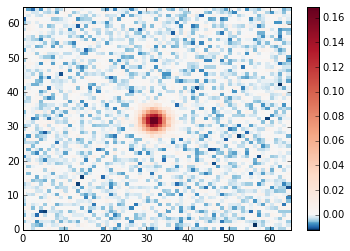

In [19]:
%matplotlib inline
out = doGridAna(param_vec[0])

In [55]:
out = least_busy.map(doGridAna,param_vec,block=False,chunksize=1)

In [77]:
out.progress

13

In [78]:
if out.ready():
    if out.successful():
        print 'Everything Worked!'
    else:
        print 'Done, but something fucked up'
else:
    print 'Not ready yet...'

Not ready yet...


In [47]:
df = out.get()

In [50]:
a = df[0]
a[0]

,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,...,y2,y3,zeta1,zeta2,FLUX_AUTO,xctr,yctr,inputE,inputS,inputTheta
0,0.008114,0.054076,-0.042915,-0.015044,-0.019498,0.005151,-0.002263,-0.002807,0.001260,0.002495,...,-0.009749,-0.014786,-0.000277,-0.001324,-0.036077,33,33,0,5,0
0,-0.011568,-0.089748,0.023237,-0.016757,-0.052741,-0.002667,0.000541,-0.000367,-0.005194,-0.010395,...,-0.026370,0.008738,-0.000430,0.000107,-0.048824,33,585,0,5,0
0,0.005927,-0.043220,-0.027361,-0.004194,-0.086071,-0.000856,0.000087,-0.002096,-0.004713,-0.009435,...,-0.043036,-0.001255,0.000928,-0.000732,-0.047876,33,1137,0,5,0
0,0.001158,-0.161213,0.006605,-0.002605,-0.035930,-0.005174,0.001060,0.000735,-0.007186,-0.014405,...,-0.017965,-0.039270,-0.000709,-0.000786,-0.026265,33,1689,0,5,0
0,-0.002445,0.050427,-0.042800,-0.006054,0.049228,0.004287,-0.000787,0.001049,0.003632,0.007250,...,0.024614,0.022552,-0.000610,0.000942,0.118834,91,33,0,5,0
0,-0.013281,0.147252,-0.044323,0.019650,-0.035273,0.001860,0.000206,0.000618,0.004082,0.008081,...,-0.017637,0.013461,-0.000219,0.000559,0.065057,91,585,0,5,0
0,0.011202,0.009851,0.044914,0.015822,-0.038523,-0.005949,0.002240,-0.002646,-0.001045,-0.002111,...,-0.019262,0.031971,0.000155,-0.000043,-0.047934,91,1137,0,5,0
0,0.015997,0.022830,0.037385,-0.008587,0.070462,-0.002300,-0.001600,-0.001406,0.003400,0.006785,...,0.035231,-0.023748,-0.001105,-0.001092,0.011369,91,1689,0,5,0
0,0.015967,0.061854,0.031656,-0.004415,-0.066396,0.006669,0.000617,0.003519,-0.000166,-0.000373,...,-0.033198,-0.020372,0.001249,0.000638,-0.028530,150,33,0,5,0
0,-0.021969,-0.028359,-0.005528,-0.006008,-0.037664,-0.002120,0.001039,-0.003156,-0.002407,-0.004813,...,-0.018832,0.000441,0.000540,-0.001041,-0.070062,150,585,0,5,0


In [54]:
import pandas as pd
end_res = pd.DataFrame()
for i in np.arange(len(df)):
    current = df[i]
    temp = current[0][0]-current[1][0] #fitted-ideal
    temp['inputE'] = current[0][0]['inputE']
    temp['inputS'] = current[0][0]['inputS']
    temp['inputTheta'] = current[0][0]['inputTheta']
    end_res = end_res.append(temp)

In [55]:
end_res.columns

Index([u'Mx', u'Mxx', u'Mxy', u'My', u'Myy', u'a4', u'delta1', u'delta2',
       u'e0', u'e0prime', u'e1', u'e2', u'flux', u'fwhm', u'phi', u'w', u'w1',
       u'w2', u'wd1', u'wd2', u'whisker', u'x2', u'x2y', u'x3', u'xy', u'xy2',
       u'y2', u'y3', u'zeta1', u'zeta2', u'inputE', u'inputS', u'inputTheta'],
      dtype='object')

In [56]:
end_res

,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,...,x3,xy,xy2,y2,y3,zeta1,zeta2,inputE,inputS,inputTheta
0,-0.012650,0.010879,0.000276,-0.054885,0.000186,0.001113,-6.681811e-06,-0.000046,0.000403,0.000823,...,-0.004029,0.000138,-0.001230,0.000093,0.007034,-0.000104,0.000169,0.0,2,0
0,-0.023359,0.014063,0.010568,-0.048458,-0.003198,0.001807,-2.071581e-05,-0.000096,0.000396,0.000812,...,0.001254,0.005284,0.000769,-0.001599,0.004638,0.000040,0.000090,0.0,2,0
0,-0.011816,0.017987,0.000398,-0.042204,0.002640,0.001553,-1.717189e-04,-0.000108,0.000752,0.001526,...,-0.006559,0.000199,0.000722,0.001320,0.001111,-0.000115,-0.000007,0.0,2,0
0,-0.014667,0.006366,-0.005532,-0.046711,0.008065,0.001972,-1.244447e-04,0.000005,0.000526,0.001048,...,-0.003516,-0.002766,0.000936,0.004033,0.002093,-0.000051,0.000057,0.0,2,0
0,-0.015577,0.006995,0.007651,-0.046784,0.013194,0.003453,-6.284695e-07,-0.000005,0.000736,0.001459,...,0.001912,0.003826,0.000648,0.006597,0.003011,0.000050,0.000077,0.0,2,0
0,-0.001467,0.011946,0.002191,-0.040676,0.014786,0.001360,-2.360705e-05,-0.000086,0.000974,0.001945,...,-0.002911,0.001096,-0.000571,0.007393,0.002518,-0.000069,0.000037,0.0,2,0
0,0.001611,-0.007292,0.002278,-0.035437,0.009742,-0.003255,8.609040e-05,-0.000084,0.000089,0.000147,...,0.000303,0.001139,-0.001357,0.004871,0.001577,-0.000021,0.000013,0.0,2,0
0,0.001344,0.001583,-0.011435,-0.038070,0.003768,-0.001852,8.514717e-05,0.000027,0.000195,0.000381,...,0.002436,-0.005717,-0.000630,0.001884,-0.000060,0.000036,0.000007,0.0,2,0
0,0.007408,0.006572,-0.000821,-0.046675,0.002123,0.000385,-4.220138e-05,0.000073,0.000317,0.000641,...,0.000083,-0.000410,0.000742,0.001061,-0.000245,0.000016,0.000018,0.0,2,0
0,0.006783,0.009735,0.002184,-0.048996,0.009866,0.000315,4.608705e-06,0.000040,0.000714,0.001429,...,0.003806,0.001092,0.001191,0.004933,-0.001384,0.000098,-0.000023,0.0,2,0


In [57]:
end_res.to_csv('../data/des_noTR_outputDF2.csv')

In [210]:
import matplotlib.pyplot as plt
obj = galsim.Sersic(4,half_light_radius=2) #deV profile
obj = obj.shear(e=.1,beta=galsim.Angle(45,galsim.degrees))
img = galsim.Image(500,500,scale=1)
obj.drawImage(image=img)
plt.imshow(img.array)

RuntimeError: SB Error: fourierDraw() requires an FFT that is too large, 16916
If you can handle the large FFT, you may update gsparams.maximum_fft_size.

In [212]:
obj.xValue(1,1)

0.022755310785120282

In [296]:
lsst_mg = MoveableGrid('../data/test100k_iter.pkl')
lsst_flat = np.load('7th_order_LSST_50x50.npy')

#for DES
des_mg = MoveableGrid('../data/des_50x50_100k_iter_noTR.pkl')
des_flat = np.load('../data/des_50x50_testFlat.npy')

In [136]:
import numpy as np
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
from weak_sauce.grid import MoveableGrid
saved_mg = MoveableGrid('../data/best_lsst_amp3_mg.pkl')
#saved_mg = MoveableGrid('/nfs/slac/g/ki/ki19/des/mbaumer/ccd_mg_model_fits/des_chip01_maxit100000_step0.1_decay0.0/mg.pkl')
flat = np.load('../data/big_lsst_flat.npy')

In [137]:
saved_mg.source.fluxes.shape

(242, 1722)

In [3]:
saved_mg.source.vertices.shape

(825, 3897, 2)

In [4]:

saved_mg.source.vertices = saved_mg.source.vertices[0:100,0:100,:]
saved_mg.source.fluxes = saved_mg.source.fluxes[0:100,0:100]


(<matplotlib.figure.Figure at 0x7fef61f38d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fef64d68a50>)

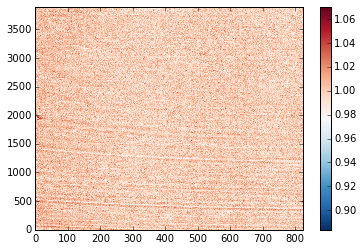

In [7]:
%matplotlib inline
saved_mg.plot_real_grid()

In [9]:
test = np.arange(10)

In [11]:
test[1:4]

array([1, 2, 3])

In [79]:
np.linspace(100,200,num=3)

array([ 100.,  150.,  200.])

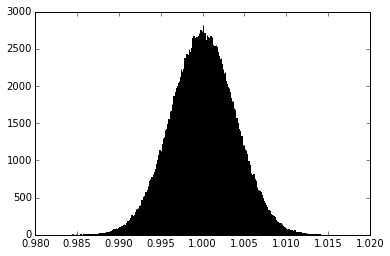

In [148]:
import matplotlib.pyplot as plt
_ = plt.hist(flat.flatten(),bins=500)